# Harris County Home Price Estimations


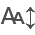

In [26]:
import os
from datetime import datetime

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from itables import init_notebook_mode, show
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from load_to_dataframe import load_housing_data, load_mailing_data

init_notebook_mode(all_interactive=True)
%matplotlib inline

# Load Data
In the file **load_to_dataframe.py** there is a function that will load the housing data from the *housing_data.zip* into a data frame. There was some processing of the data so that the CSV would be under 100mb to work with a git repo. Below are the filter that took place. 

* Only houses with improvement type 1001 (single family homes) will be selected
* The date erected must be greater than 1900
* The assessed value must be greater than 0
* the square footage must be greater than 50

In [27]:
df = load_housing_data()

# Haversine Function
The haversine function is used to calculate the distance between two sets of latitude and longitude coordinates. In this case one of the fixed points is the center of downtown Houston (29.760100, -95.370100). The assumption is, the closer to Houston's downtown, the higher the value.

In [28]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of Earth in miles
    r = 3958.8
    # Convert degrees to radians
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    # Haversine formula
    a = np.sin(d_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return r * c


# Define the single point (latitude, longitude) to calculate the distance from
single_point = (29.760100, -95.370100)  # Houston

# Add a new column with distances
df["distance_miles"] = df.apply(
    lambda row: haversine(
        single_point[0], single_point[1], row["latitude"], row["longitude"]
    ),
    axis=1,
)

# Grouping Account Numbers
There are multiple account numbers for properties with multiple buildings, and most of the data is repeated for the different buildings other than the bld_num, date_erected, im_sq_ft, dscr_e, and the perimeter. The rest of the features can have the mean taken and it will be the same number pressent. 
The dscr_e is an ordial field and the average of the buildings will be used. 

In [29]:
df = (
    df.groupby("acct")
    .agg(
        bld_num=("bld_num", "max"),
        date_erected=("date_erected", "min"),
        im_sq_ft=("im_sq_ft", "sum"),
        land_ar=("land_ar", "mean"),
        perimeter=("perimeter", "sum"),
        bedrooms=("bedrooms", "mean"),
        full_bath=("full_bath", "mean"),
        half_bath=("half_bath", "mean"),
        total_rooms=("total_rooms", "mean"),
        dscr_e=("dscr_e", "mean"),
        frame_detached_garage=("frame_detached_garage", "mean"),
        gunite_pool=("gunite_pool", "mean"),
        pool_heater=("pool_heater", "mean"),
        solar_panel=("solar_panel", "mean"),
        brick_garage=("brick_garage", "mean"),
        canopy_residential=("canopy_residential", "mean"),
        frame_abov=("frame_abov", "mean"),
        frame_shed=("frame_shed", "mean"),
        carport_residential=("carport_residential", "mean"),
        foundation_repaired=("foundation_repaired", "mean"),
        cracked_slab=("cracked_slab", "mean"),
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean"),
        distance_miles=("distance_miles", "mean"),
        land_val=("land_val", "mean"),
        bld_val=("bld_val", "mean"),
        assessed_val=("assessed_val", "mean"),
    )
    .reset_index()
)
df["assessed_per_sqft"] = df["assessed_val"] / df["im_sq_ft"]
df

acct  bld_num  date_erected  im_sq_ft  land_ar  perimeter  \
0          20720000014        1          2019      2534   5564.0        452   
1          21440000001        1          2004      2537   5000.0        314   
2          21480000002        1          1917      1496   5000.0        186   
3          21650000007        1          2015      3387   5000.0        578   
4          21650000011        1          2003      1508   6250.0        210   
...                ...      ...           ...       ...      ...        ...   
1095702  1938003804013        1          2003      2117   5250.0        318   
1095703  1938003804014        1          2003      1611   5250.0        184   
1095704  1953050320690        1          1979      2168   6820.0        232   
1095705  1953080320060        1          1983      1723   7575.0        216   
1095706  1955020050280        1          1979      1374   8851.0        250   

         bedrooms  full_bath  half_bath  total_rooms  ...  \
0             3.0        3.0        1.0          6.0  ...   
1             3.0        2.0        1.0          8.0  ...   
2             3.0        1.0        0.0          6.0  ...   
3             3.0        3.0        1.0          6.0  ...   
4             3.0        2.0        0.0          5.0  ...   
...           ...        ...        ...          ...  ...   
1095702       3.0        2.0        1.0          7.0  ...   
1095703       3.0        2.0        0.0          6.0  ...   
1095704       3.0        2.0        0.0          5.0  ...   
1095705       3.0        2.0        0.0          6.0  ...   
1095706       3.0        2.0        1.0          5.0  ...   

         carport_residential  foundation_repaired  cracked_slab   latitude  \
0                        0.0                  0.0           0.0  29.743903   
1                        0.0                  0.0           0.0  29.740005   
2                        0.0                  0.0           0.0  29.742185   
3                        0.0                  0.0           0.0  29.741158   
4                        0.0                  0.0           0.0  29.741294   
...                      ...                  ...           ...        ...   
1095702                  0.0                  0.0           0.0  29.594555   
1095703                  0.0                  0.0           0.0  29.594558   
1095704                  0.0                  0.0           0.0  29.694444   
1095705                  0.0                  0.0           0.0  29.694102   
1095706                  0.0                  0.0           0.0  29.702614   

         longitude  distance_miles  land_val   bld_val  assessed_val  \
0       -95.356534        1.383701  253352.0  451951.0      705303.0   
1       -95.358428        1.554979  200000.0  307658.0      510178.0   
2       -95.361765        1.334974  200000.0    9486.0      209586.0   
3       -95.361889        1.398421  200000.0  523919.0      723919.0   
4       -95.361493        1.398188  225000.0  172034.0      397034.0   
...            ...             ...       ...       ...           ...   
1095702 -95.453635       12.489168   35438.0  233603.0      269041.0   
1095703 -95.453478       12.485174   35438.0  204053.0      239491.0   
1095704 -95.658936       17.914352   54560.0  201010.0      255570.0   
1095705 -95.658271       17.881794   55740.0  173156.0      228896.0   
1095706 -95.673357       18.623451   64580.0  160896.0      225476.0   

         assessed_per_sqft  
0               278.335833  
1               201.094994  
2               140.097594  
3               213.734573  
4               263.285146  
...                    ...  
1095702         127.085971  
1095703         148.659839  
1095704         117.882841  
1095705         132.847359  
1095706         164.101892  

[1095707 rows x 29 columns]

# Price Per Square Foot
This is another metric that I will explore to see if there is a relationship between other values. This data will be cleaned and also a test since any property with 0 square feet will return a divide by zero error, so the row will be dropped.

In [30]:
df["assessed_per_sqft"].describe()

count    1.095707e+06
mean     1.612878e+02
std      7.578459e+01
min      1.785714e+00
25%      1.241208e+02
50%      1.429477e+02
75%      1.695208e+02
max      5.090190e+03
Name: assessed_per_sqft, dtype: float64

In [31]:
df["assessed_val"].describe()

count    1.095707e+06
mean     3.726411e+05
std      4.020768e+05
min      1.000000e+03
25%      2.177715e+05
50%      2.818750e+05
75%      3.887865e+05
max      2.673551e+07
Name: assessed_val, dtype: float64

In [32]:
sample_df = df.sample(n=10000, random_state=42)
show(sample_df)
sample_df.to_csv("sample_housing_data.csv")

# Feature Scaling
The features will be scaled to be between 0 and 1

In [7]:
from sklearn.preprocessing import MinMaxScaler

columns_to_scale = [
    "date_erected",
    "im_sq_ft",
    "land_ar",
    "perimeter",
    "bedrooms",
    "full_bath",
    "half_bath",
    "total_rooms",
    "dscr_e",
    "frame_detached_garage",
    "gunite_pool",
    "pool_heater",
    "solar_panel",
    "brick_garage",
    "canopy_residential",
    "frame_abov",
    "frame_shed",
    "carport_residential",
    "foundation_repaired",
    "cracked_slab",
    "latitude",
    "longitude",
    "distance_miles",
]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [8]:
df.columns

Index(['acct', 'bld_num', 'date_erected', 'im_sq_ft', 'land_ar', 'perimeter',
       'bedrooms', 'full_bath', 'half_bath', 'total_rooms', 'dscr_e',
       'frame_detached_garage', 'gunite_pool', 'pool_heater', 'solar_panel',
       'brick_garage', 'canopy_residential', 'frame_abov', 'frame_shed',
       'carport_residential', 'foundation_repaired', 'cracked_slab',
       'latitude', 'longitude', 'distance_miles', 'land_val', 'bld_val',
       'assessed_val', 'assessed_per_sqft'],
      dtype='object')

In [9]:
df.head()

acct  bld_num  date_erected  im_sq_ft   land_ar  perimeter  \
0  20720000014        1      0.959350  0.009869  0.000981   0.020520   
1  21440000001        1      0.837398  0.009882  0.000882   0.016306   
2  21480000002        1      0.130081  0.005554  0.000882   0.012397   
3  21650000007        1      0.926829  0.013415  0.000882   0.024367   
4  21650000011        1      0.829268  0.005604  0.001102   0.013130   

   bedrooms  full_bath  half_bath  total_rooms  ...  carport_residential  \
0  0.006682   0.007282   0.043478     0.006536  ...                  0.0   
1  0.006682   0.004854   0.043478     0.008715  ...                  0.0   
2  0.006682   0.002427   0.000000     0.006536  ...                  0.0   
3  0.006682   0.007282   0.043478     0.006536  ...                  0.0   
4  0.006682   0.004854   0.000000     0.005447  ...                  0.0   

   foundation_repaired  cracked_slab  latitude  longitude  distance_miles  \
0                  1.0           1.0  0.365977   0.576229        0.021977   
1                  1.0           1.0  0.360136   0.574402        0.025894   
2                  1.0           1.0  0.363402   0.571183        0.020863   
3                  1.0           1.0  0.361862   0.571063        0.022314   
4                  1.0           1.0  0.362067   0.571445        0.022309   

   land_val   bld_val  assessed_val  assessed_per_sqft  
0  253352.0  451951.0      705303.0         278.335833  
1  200000.0  307658.0      510178.0         201.094994  
2  200000.0    9486.0      209586.0         140.097594  
3  200000.0  523919.0      723919.0         213.734573  
4  225000.0  172034.0      397034.0         263.285146  

[5 rows x 29 columns]

# Reduce data set to a manageable size
The current data set is over 1.1M rows. This would take **DAYS** to train a model on a regular computer. This is after the initial filtering when extracting the data from the SQLite database.

To reduce the number of houses and remove outliers I will use the inner quartile range to remove the outliers.


In [10]:
print(f"There are {df.shape[0]:,} rows and {df.shape[1]} columns in the df Data Frame.")

There are 1,095,707 rows and 29 columns in the df Data Frame.


In [11]:
# # IQR
# Q1 = df["assessed_val"].quantile(0.25)
# Q3 = df["assessed_val"].quantile(0.75)
# IQR = Q3 - Q1

# lower_iqr = Q1 - 1.5 * IQR
# upper_iqr = Q3 + 1.5 * IQR
# print(f"Lower IQR: {lower_iqr} | Upper IQR: {upper_iqr}")

# df = df[(df["assessed_val"] <= upper_iqr)]

In [12]:
df["assessed_val"].describe()

count    1.095707e+06
mean     3.726411e+05
std      4.020768e+05
min      1.000000e+03
25%      2.177715e+05
50%      2.818750e+05
75%      3.887865e+05
max      2.673551e+07
Name: assessed_val, dtype: float64

In [13]:
y = df["assessed_val"]
y_per_sqft = df["assessed_per_sqft"]

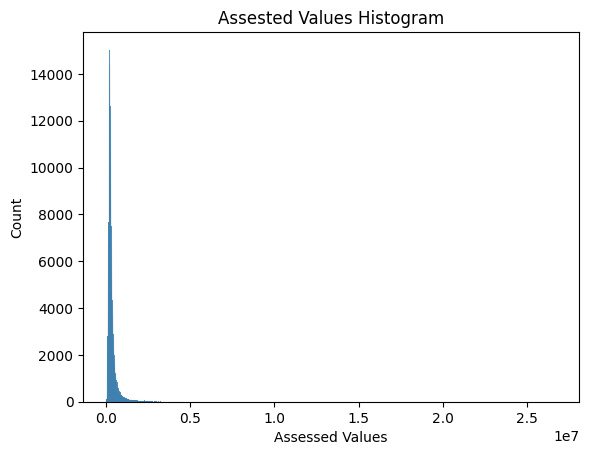

In [14]:
sns.histplot(y)
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram")
plt.show()

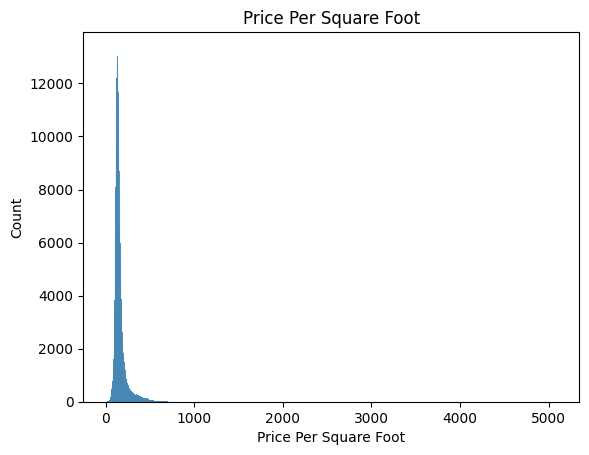

In [15]:
sns.histplot(y_per_sqft)
plt.xlabel("Price Per Square Foot")
plt.ylabel("Count")
plt.title("Price Per Square Foot")
plt.show()

## Sample Size Reduction
Since the data set is still over 1M homes, we need to reduce the size to create a model. I will use 10 thousand random samples from the full data frame.

In [16]:
sample_df = df.sample(n=10000, random_state=42)
show(sample_df)
sample_df.to_csv("sample_housing_data.csv")

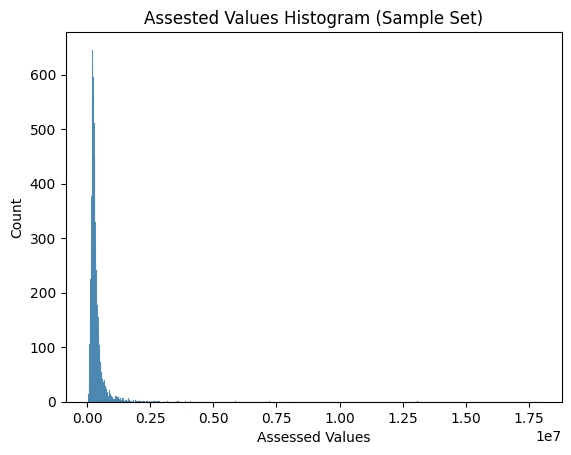

In [17]:
sns.histplot(sample_df["assessed_val"])
plt.xlabel("Assessed Values")
plt.ylabel("Count")
plt.title("Assested Values Histogram (Sample Set)")
plt.show()

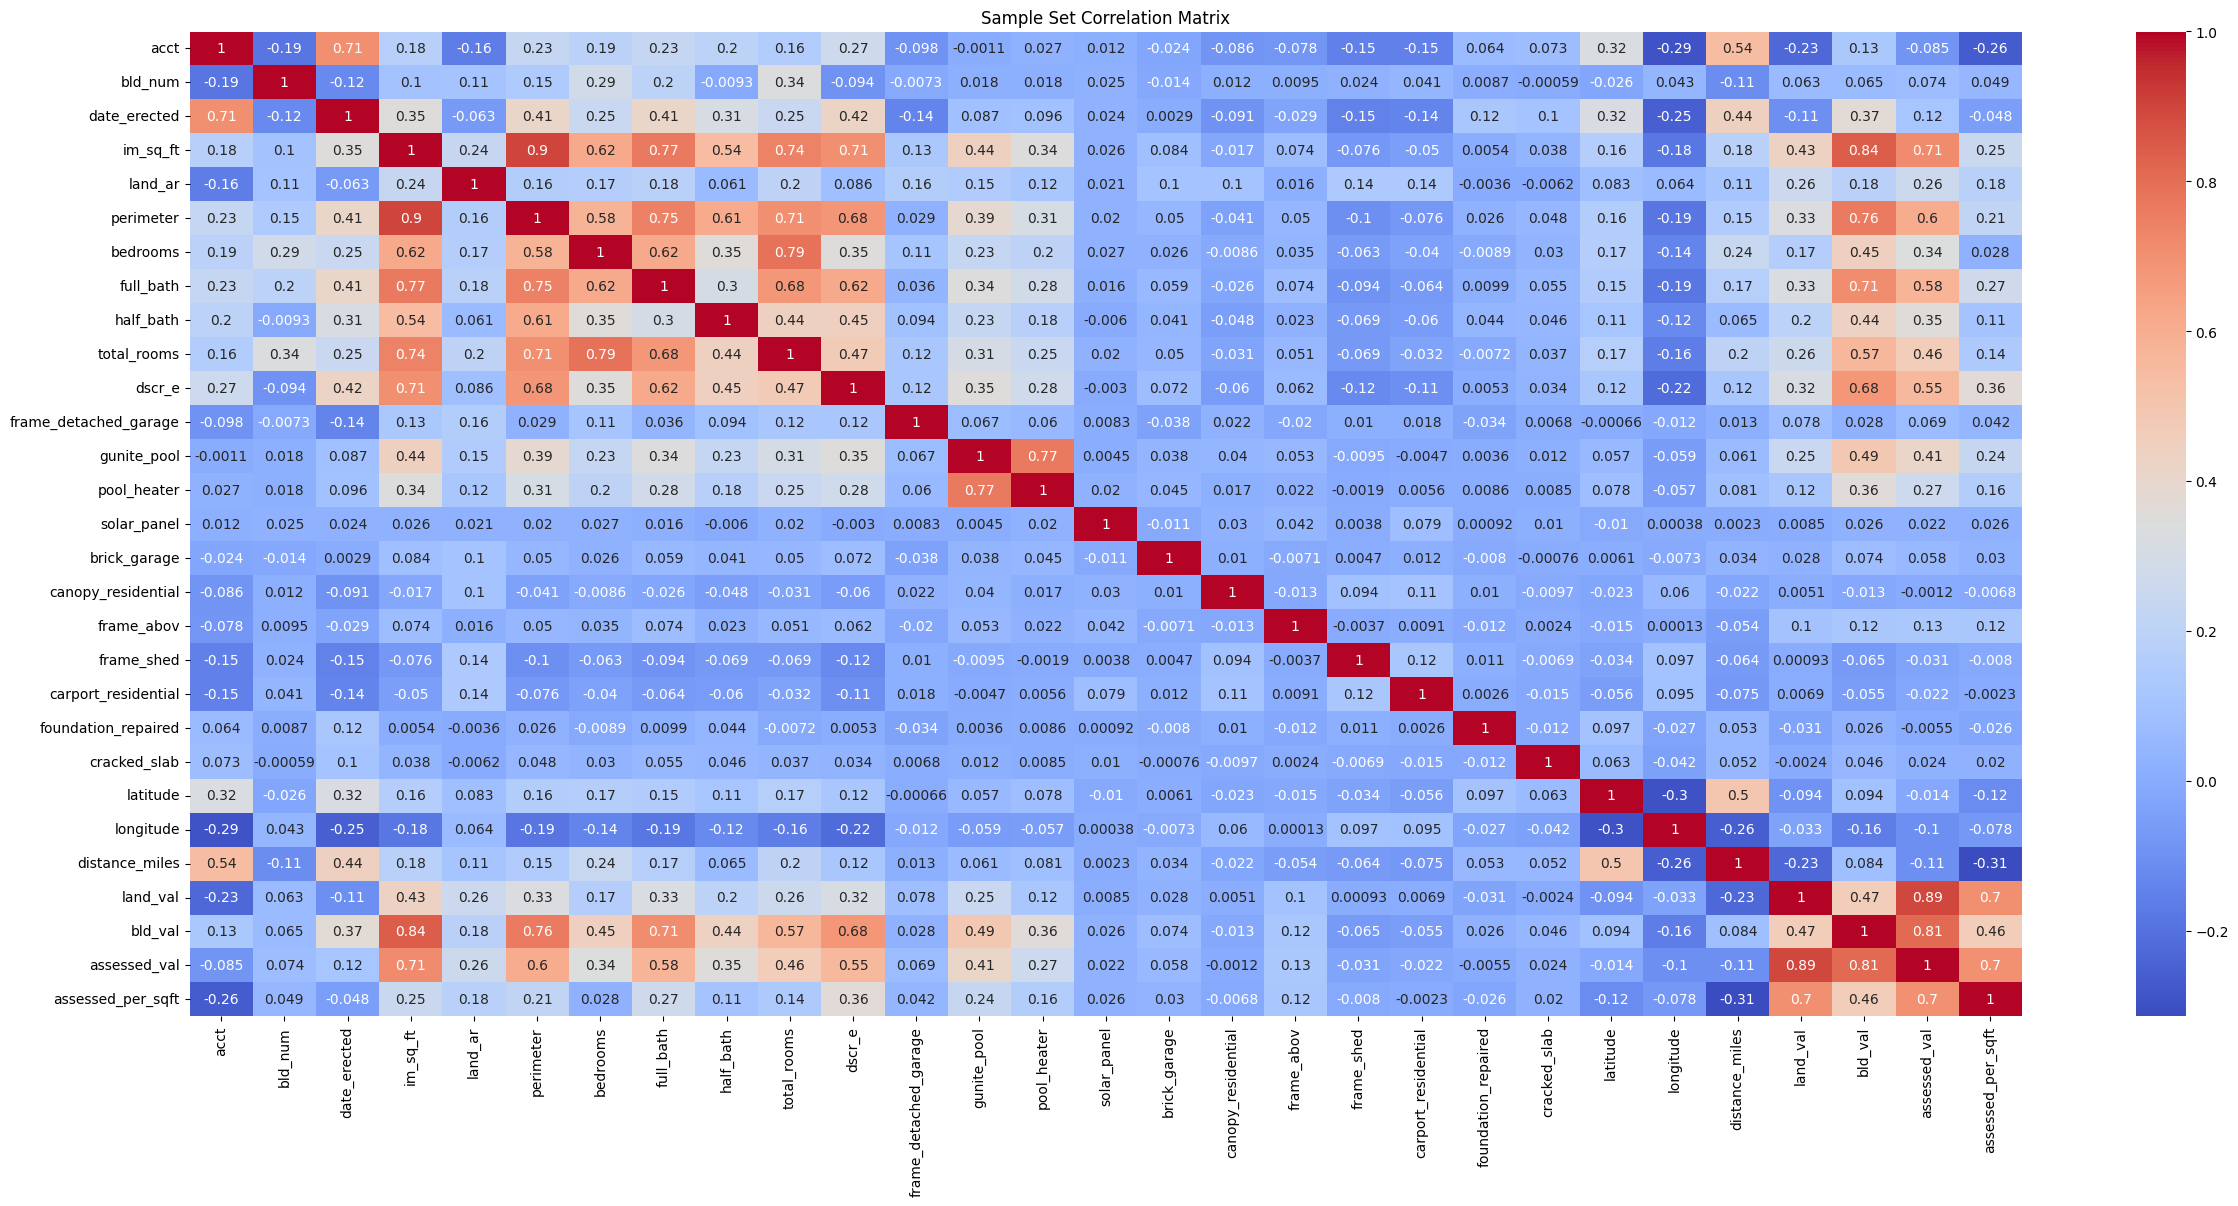

In [18]:
corr_matrix = sample_df.corr()
plt.figure(figsize=(25, 12))
sns.heatmap(data=corr_matrix, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.title("Sample Set Correlation Matrix")
plt.show()

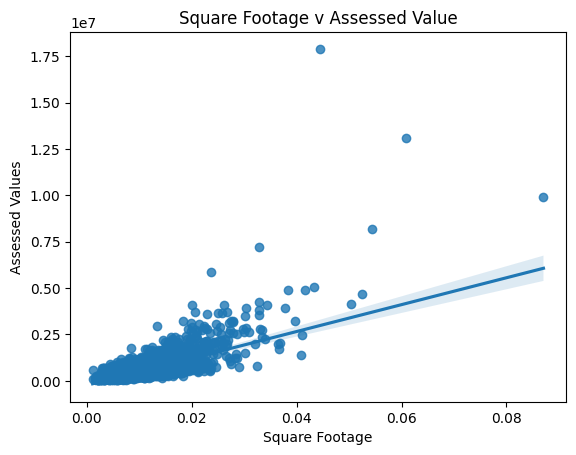

In [19]:
sns.regplot(sample_df, x="im_sq_ft", y="assessed_val")
plt.xlabel("Square Footage")
plt.ylabel("Assessed Values")
plt.title("Square Footage v Assessed Value")
plt.show()

# Create the features as X

In [20]:
X = sample_df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]

y = sample_df["assessed_val"]
print(f"There are {X.shape[1] + 1} features in total.")

There are 23 features in total.


# Train, Test, Split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [22]:
x_train.describe()

date_erected     im_sq_ft      land_ar    perimeter     bedrooms  \
count   7000.000000  7000.000000  7000.000000  7000.000000  7000.000000   
mean       0.698348     0.008479     0.001657     0.015326     0.007627   
std        0.195156     0.004138     0.002356     0.003490     0.001863   
min        0.073171     0.001081     0.000000     0.006718     0.000000   
25%        0.560976     0.005729     0.001028     0.012825     0.006682   
50%        0.715447     0.007583     0.001276     0.014291     0.006682   
75%        0.853659     0.010272     0.001622     0.017222     0.008909   
max        1.000000     0.060765     0.064819     0.048307     0.044543   

         full_bath    half_bath  total_rooms     latitude    longitude  ...  \
count  7000.000000  7000.000000  7000.000000  7000.000000  7000.000000  ...   
mean      0.005169     0.019826     0.007602     0.503748     0.509450  ...   
std       0.001815     0.022976     0.001879     0.217068     0.197958  ...   
min       0.000000     0.000000     0.001089     0.007007     0.028695  ...   
25%       0.004854     0.000000     0.006536     0.328453     0.357223  ...   
50%       0.004854     0.000000     0.007625     0.495657     0.498214  ...   
75%       0.004854     0.043478     0.008715     0.678255     0.674560  ...   
max       0.021845     0.173913     0.037037     0.991894     0.994958  ...   

       gunite_pool  pool_heater  brick_garage  canopy_residential  \
count  7000.000000  7000.000000   7000.000000         7000.000000   
mean      0.001946     0.001660      0.000616            0.001619   
std       0.007353     0.007787      0.005999            0.008493   
min       0.000000     0.000000      0.000000            0.000000   
25%       0.000000     0.000000      0.000000            0.000000   
50%       0.000000     0.000000      0.000000            0.000000   
75%       0.000000     0.000000      0.000000            0.000000   
max       0.149553     0.078704      0.184302            0.324996   

        frame_abov   frame_shed  carport_residential  foundation_repaired  \
count  7000.000000  7000.000000          7000.000000          7000.000000   
mean      0.000349     0.003807             0.000999             0.996655   
std       0.005600     0.015914             0.007541             0.026505   
min       0.000000     0.000000             0.000000             0.617292   
25%       0.000000     0.000000             0.000000             1.000000   
50%       0.000000     0.000000             0.000000             1.000000   
75%       0.000000     0.000000             0.000000             1.000000   
max       0.300693     0.419048             0.372751             1.000000   

       cracked_slab  distance_miles  
count   7000.000000     7000.000000  
mean       0.998459        0.344097  
std        0.016355        0.162939  
min        0.666448        0.003471  
25%        1.000000        0.211133  
50%        1.000000        0.351752  
75%        1.000000        0.474910  
max        1.000000        0.907755  

[8 rows x 22 columns]

In [23]:
y_train.describe()

count    7.000000e+03
mean     3.722741e+05
std      4.275313e+05
min      4.807100e+04
25%      2.186195e+05
50%      2.832015e+05
75%      3.870425e+05
max      1.790370e+07
Name: assessed_val, dtype: float64

# Extra Random Trees
Using GridSearchCV for hyperparameter tuning. If this is done, it will increase the model's runtime to take several hours, and depending on the sample size and parameters, the computer may need up to 64 GB of RAM to process the models. If the computer has 32 GB, ensure the n_jobs = 4 or less. If the computer has 16gb of ram put n_jobs=1. n_jobs is the parallel jobs going simultaneously and consuming more resources. 

In [24]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from scipy.stats import randint, uniform

In [25]:
etr = ExtraTreesRegressor(random_state=42)


param_grid = {
    "n_estimators": randint(100, 4000),
    "max_depth": randint(1, 50),
    "min_samples_leaf": randint(1, 10),
    "min_samples_split": randint(2, 20),
    "max_features": uniform(0.1, 0.9),
}


# etr_cv = GridSearchCV(
#     etr, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
# )

etr_cv = HalvingRandomSearchCV(
    estimator=etr,
    param_distributions=param_grid,
    factor=2,
    random_state=42,
    cv=3,
    n_jobs=-1,
    scoring="neg_mean_squared_error",
    verbose=2,
)


etr_cv.fit(x_train, y_train)

n_iterations: 11
n_required_iterations: 11
n_possible_iterations: 11
min_resources_: 6
max_resources_: 7000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1166
n_resources: 6
Fitting 3 folds for each of 1166 candidates, totalling 3498 fits


KeyboardInterrupt: 

In [ ]:
etr_cv.best_score_

In [ ]:
etr_cv.best_params_

In [ ]:
feature_names = [f"{i}" for i in X.columns]
best_model = etr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [ ]:
ert_cv_results = pd.DataFrame(etr_cv.cv_results_)
ert_cv_results["param_n_estimators"] = ert_cv_results["param_n_estimators"].astype(
    "category"
)
ert_cv_results

# Savings the model
The model will be save to the hard drive so it can be used later without having to run the entire ExtraTreesRegression model again. 

In [ ]:
# Define the folder name
folder_name = "Models"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

# Get the current date
current_date = datetime.now()

# Format the date as YYYYmmdd
formatted_date = current_date.strftime("%Y%m%d_%H%M")

joblib.dump(etr_cv, f"Models/etc_{formatted_date}_.pkl", compress=("xz", 3))

## Analysis of testing data

In [ ]:
etr_pred = etr_cv.predict(x_test)
etr_mae = mean_absolute_error(y_test, etr_pred)
etr_mse = mean_squared_error(y_test, etr_pred)
etr_r2 = r2_score(y_test, etr_pred)
print(f"MAE: {etr_mae}\nMSE: {etr_mse}\nR Squared: {etr_r2}\n")

In [ ]:
actual = y_test.to_list()
predicted = etr_cv.predict(x_test)
etc_residuals = pd.DataFrame({"actual": actual, "predicted": predicted})
etc_residuals["residuals"] = etc_residuals["actual"] - etc_residuals["predicted"]

In [ ]:
sns.regplot(etc_residuals, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (ERT Regression of Testing Set)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {etr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

# Residual Analysis

In [ ]:
y_train_pred = etr_cv.predict(x_train)
y_test_pred = etr_cv.predict(x_test)

In [ ]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

In [ ]:
# Train set residuals
plt.scatter(y_train_pred, train_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Train Set)")
plt.show()

In [ ]:
plt.hist(train_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Train Set)")
plt.show()

In [ ]:
# Test set residuals
plt.scatter(y_test_pred, test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Values (Test Set)")
plt.show()

In [ ]:
plt.hist(test_residuals, bins=30, edgecolor="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Test Set)")
plt.show()

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(test_residuals)
if p > 0.05:
    print(f"Residuals are normally distributed (p > 0.05, p={p}) .")
else:
    print(f"Residuals are not normally distributed (p <= 0.05, p={p}).")

In [ ]:
plt.scatter(range(len(y_test)), test_residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residuals Plot Across Index")
plt.show()

## Z-Score of the outliers
These indexes are results that are stastically different from the models prediction and may need to be indivially reviewed. 

In [ ]:
import numpy as np

z_scores = np.abs((test_residuals - np.mean(test_residuals)) / np.std(test_residuals))
outliers = np.where(z_scores > 3)
print(f"Outlier indices: {outliers}")

In [ ]:
from statsmodels.api import OLS
import statsmodels.api as sm

model_ols = sm.OLS(y_train, sm.add_constant(x_train)).fit()
influence = model_ols.get_influence()
cooks_d = influence.cooks_distance

## Gradient Boosting Regression

Gradient boosting is another ensemble algorithm that can be used much like Extra Random Trees. It differs in the way that it makes the trees. In gradient boosting new trees are added to correct errors of the previous tress in a sequential manner, while extra random trees builds tress independently by randomly selecting features and split points at each node, which makes it less prone to overfitting compared to gradient boosting which can be more sensitive to overfitting.

In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    "n_estimators": [4000],
    "learning_rate": [0.01],
    "max_depth": [5],
    "min_samples_split": [3],
    "min_samples_leaf": [1],
    "max_features": [10],
    "warm_start": [True],
    "criterion": ["squared_error"],
}
gbr_cv = GridSearchCV(
    gbr, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
)

In [ ]:
gbr_cv.fit(x_train, y_train)
gbr_pred = gbr_cv.predict(x_test)

In [ ]:
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_mse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)
print(f"MAE: {gbr_mae}\nMSE: {gbr_mse}\nR Squared: {gbr_r2}\n")

In [ ]:
gbr_cv.best_params_

In [ ]:
feature_names = [f"{i}" for i in X.columns]
best_model = gbr_cv.best_estimator_
feature_importances = best_model.feature_importances_

# Rank the features by importance
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values(by="Importance", ascending=False)

# Graph the importance of the features
importance_df.plot(kind="bar", x="Feature", y="Importance", legend=False)
plt.title("Feature Importance's")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

In [ ]:
gbr_cv.best_score_

In [ ]:
joblib.dump(gbr_cv, f"Models/gbr_{formatted_date}_.pkl", compress=("xz", 3))

# load
# joblib.load('gbr.pkl')s

In [ ]:
gbr_residual_df = pd.DataFrame(
    {
        "actual": actual,
        "predicted": gbr_pred,
    }
)
gbr_residual_df["residuals"] = gbr_residual_df["actual"] - gbr_residual_df["predicted"]

In [ ]:
sns.regplot(gbr_residual_df, x="actual", y="predicted")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Actual v Predicted (GB Regression)")

plt.text(
    0.95,
    0.05,
    f"$R^2 = {gbr_r2:.2f}$",
    horizontalalignment="right",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
)
plt.show()

In [ ]:
sns.scatterplot(gbr_residual_df, x="actual", y="residuals")
plt.xlabel("Assessed Values")
plt.ylabel("Predicted Values")
plt.title("Residuals of Actual v Predicted (GB Regression)")
plt.show()

# Apply model to entire dataset
The model was created with a random subset of the data to reduce the training time. This will apply the model to the rest of the dataset.

In [ ]:
X = df[
    [
        "date_erected",
        "im_sq_ft",
        "land_ar",
        "perimeter",
        "bedrooms",
        "full_bath",
        "half_bath",
        "total_rooms",
        "latitude",
        "longitude",
        "dscr_e",
        "frame_detached_garage",
        "gunite_pool",
        "pool_heater",
        "brick_garage",
        "canopy_residential",
        "frame_abov",
        "frame_shed",
        "carport_residential",
        "foundation_repaired",
        "cracked_slab",
        "distance_miles",
    ]
]
df["ert_predicted"] = etr_cv.predict(X)
df["gbr_predicted"] = gbr_cv.predict(X)

In [ ]:
df[["assessed_val", "ert_predicted", "gbr_predicted"]]

# Merge Mailing Address
Merge the Mailing Address information with the properties to protest.

**Need to redo the import of the mailing data from a single file if the database does not exist.**

In [ ]:
mail_addr = load_mailing_data()
df = df.merge(mail_addr, how="left", left_on="acct", right_on="acct")

# Properties that should be protested

In [ ]:
protest_ert = df.query("assessed_val <= ert_predicted")
protest_gbr = df.query("assessed_val <= gbr_predicted")

In [ ]:
total = df.shape[0]
count_ert = protest_ert.shape[0]
count_gbr = protest_gbr.shape[0]
print(
    f"Total Accounts: {total}, Extra Trees: {count_ert}, Gradient Boosting Regressor: {count_gbr}"
)

In [ ]:
# Define the folder name
folder_name = "Output"

# Check if the folder exists, and create it if it doesn't
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


def output_dataframe_csv(df_name, name):
    df_name.to_csv(f"Output/{name}.csv", index=False)

In [ ]:
output_dataframe_csv(df, "All_Data")
output_dataframe_csv(protest_ert, "Protest_Data_Extra_Trees")
output_dataframe_csv(protest_gbr, "Protest_Data_Extra_GBR")

## Proportions of homes to be send advertiments

In [ ]:
percent_etr = (count_ert / total) * 100
percent_gbr = (count_gbr / total) * 100
print(
    f"Extra Random Trees regression model predicts that {percent_etr:.2f}% of total accounts should be protested.\nGradient Boosting Regressor: {percent_gbr:.2f}% of total accounts."
)